# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based regression and classification models in order to find the one that predicts the delay with the best accuracy.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`stop_has_alert`: Indicates if there's a message about the stop being moved or cancelled.<br>
`sch_rel_Scheduled`, `sch_rel_Skipped`: States of the schedule.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair<br>
`month`, `day_of_week`, `hour`: Month, day of week and hour of the scheduled arrival time.<br>
`is_weekend`: Indicates if the day of the arrival time is on the weekend.<br>
`is_peak_hour`: Indicates of the day and hour of the arrival time is at peak hour (weekdays between 7-9am and 4-6pm).<br>
`incident_count`: Number of incidents within 500 meters of the stop.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the stop.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`windspeed`: Wind speed at 10 meters above ground, in km/h.<br>
`weather_Cloudy`, `weather_Drizzle`, `weather_Rain`: Indicates the weather category.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.<br>
`delay_class`: Delay category, from 0 (early) to 4 (late).<br>

## Imports

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from xgboost import XGBRegressor

In [3]:
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Number of rows: {len(df)}')

Number of rows: 2205086


## Split the data

In [4]:
# Train/Test Split (80-20) (stratified by delay_class)
df_train, df_temp = train_test_split(
  df,
  test_size=0.2,
  stratify=df['delay_class'],
  random_state=42
)

In [5]:
# Sample for faster experimentation (15% of the full data)
df_train_sample, _ = train_test_split(
  df_train,
  train_size=0.15,
  stratify=df_train['delay_class'],
  random_state=42
)

In [6]:
# Check is class distribution is preserved
print(df['delay_class'].value_counts(normalize=True))
print(df_train_sample['delay_class'].value_counts(normalize=True))

delay_class
1    0.871433
2    0.105529
0    0.023039
Name: proportion, dtype: float64
delay_class
1    0.871433
2    0.105529
0    0.023038
Name: proportion, dtype: float64


In [7]:
# Separate features and target
feature_cols = [col for col in df.columns if col not in ['delay', 'delay_class']]

In [8]:
# Sample train set
X_train_sample = df_train_sample[feature_cols]
y_reg_train_sample = df_train_sample['delay']
y_class_train_sample = df_train_sample['delay_class']

In [9]:
# Full train set
X_train = df_train[feature_cols]
y_reg_train = df_train['delay']
y_class_train= df_train['delay_class']

In [10]:
# Validation and test set
df_val, df_test = train_test_split(
	df_temp,
  	test_size=0.5,
    stratify=df_temp['delay_class'],
  	random_state=42
)

del df_temp

X_val = df_val[feature_cols]
y_reg_val = df_val['delay']
y_class_val = df_val['delay_class']

X_test = df_test[feature_cols]
y_reg_test = df_test['delay']
y_class_test = df_test['delay_class']

Since only tree-based models are explored in this project, **scaling is not needed** because the models are not sensitive to the absolute scale or distribution of the features.

## Regression Model

### Random Forest Regressor

#### Fit Base Model

In [11]:
rf_base = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
rf_base.fit(X_train_sample, y_reg_train_sample)

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

#### Evaluate Model

In [ ]:
# Create dataframe to track metrics
metrics_df = pd.DataFrame(columns=['model', 'params', 'MAE', 'RMSE', 'R²'])

In [ ]:
def add_metrics(metrics_df:pd.DataFrame, model, y_pred:pd.Series, y_val:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_val, y_pred)
	rmse = root_mean_squared_error(y_val, y_pred)
	r2 = r2_score(y_val, y_pred)

	metrics_df.loc[len(metrics_df)] = [model_name, model.get_params(), mae, rmse, r2]
	return metrics_df

In [ ]:
# Calculate metrics
y_pred = rf_base.predict(X_val)
metrics_df = add_metrics(metrics_df, rf_base, y_pred, y_reg_val, 'rf_base')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

**MAE**<br>
On average, the predictions are off by 73 seconds, which is not very good.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 20% of the variance in the actual delays, which is not good, but understandable considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

In [ ]:
def get_cv_scores(model, X_train:pd.DataFrame, y_train:pd.Series, k:int=5) -> pd.DataFrame:
	scoring = {
  		'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
  		'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
  		'R²': make_scorer(r2_score, greater_is_better=True)
	}
	cv_scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=k)
	return pd.DataFrame(cv_scores)

In [ ]:
# K-Fold Cross Validation
cv_scores_df = get_cv_scores(rf_base, X_train_sample, y_reg_train_sample)
cv_scores_df

In [ ]:
def add_cv_metrics(metrics_df:pd.DataFrame, cv_scores_df:pd.DataFrame, model, model_name:str) -> pd.DataFrame:
	mae = -cv_scores_df['test_MAE'].mean()
	rmse = -cv_scores_df['test_RMSE'].mean()
	r2 = cv_scores_df['test_R²'].mean()
	metrics_df.loc[len(metrics_df)] = [model_name, model.get_params(), mae, rmse, r2]

	return metrics_df

In [ ]:
# Add average metrics to dataframe
metrics_df = add_cv_metrics(metrics_df, cv_scores_df, rf_base, 'rf_base_cv')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

In [ ]:
def plot_residuals(y_pred: pd.Series, y_true:pd.Series, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted delay (seconds)')
	ax1.set_ylabel('Actual delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

In [ ]:
# Plot residual analysis
plot_residuals(y_pred, y_reg_val, 'rf_base')

The predicted vs. actual plot shows a scatter of points, with some spread around the diagonal line, which indicates the model's predictions are not perfect but are reasonable. The spread of points suggests the model has a reasonable fit but doesn't handle extreme delays very well.

From the residual plot, it seems that the residuals are fairly spread out, with visible funnel shapes and most of the data clustered around 0, but also a significant spread both above and below the 0 line. This suggests there is no clear pattern in residuals (not biased in one direction). Also, it suggests the residuals appear to increase as the predicted delay increases, meaning the model prediction errors are larger for higher predicted delays (heteroscedasticity). This means the model is better at predicting small delays than large delays.

#### Hyperparameter tuning

Due to the large volume of data, the Randomized Search will be run instead of a Grid Search. Also, it will be done manually with early stopping to save computation time, because there's no retraining from scratch each time.

In [ ]:
def random_search_rf(X_train, X_val, y_train, y_val, start_rmse:float, nb_combinations:int=10) -> dict:
	n_estimators_range = range(50, 750, 20) 
	max_depth_options = [None, 10, 20]
	max_features_options = ['sqrt', 'log2', 0.8]
	min_samples_split_options = [2, 5, 10]
	min_samples_leaf_options = [1, 2, 5]
	max_leaf_nodes_options = [None, 50, 100]

	best_rmse = start_rmse
	best_params = {}
	result = {}

	# Loop over combinations and number of trees
	for _ in range(nb_combinations):
		max_depth = random.choice(max_depth_options)
		max_features = random.choice(max_features_options)
		min_samples_split = random.choice(min_samples_split_options)
		min_samples_leaf = random.choice(min_samples_leaf_options)
		max_leaf_nodes = random.choice(max_leaf_nodes_options)
		
		rf = RandomForestRegressor(
			warm_start=True,
			n_estimators=50,
			max_depth=max_depth,
			max_features=max_features,
			min_samples_split=min_samples_split,
			min_samples_leaf=min_samples_leaf,
			max_leaf_nodes=max_leaf_nodes,
			random_state=42
		)

		errors = []
		
		for n in n_estimators_range:
			rf.n_estimators = n
			params = {
				'n_estimators': rf.n_estimators,
				'max_depth': rf.max_depth,
				'max_features': rf.max_features,
				'min_samples_split': rf.min_samples_split,
				'min_samples_leaf': rf.min_samples_leaf,
				'max_leaf_nodes': rf.max_leaf_nodes
			}

			rf.fit(X_train, y_train)
			preds = rf.predict(X_val)
			rmse = root_mean_squared_error(y_val, preds)
			errors.append(rmse)
			
			if rmse < best_rmse:
				best_rmse = rmse
				best_params = params
				result = {
					'best_rmse': best_rmse,
					'best_params': best_params
				}
	
	return result

In [ ]:
# Run random search
start_rmse = float(metrics_df['RMSE'].min())
search = random_search_rf(X_train_sample, X_val, y_reg_train_sample, y_reg_val, start_rmse)

if not search:
	print('No better parameters were found.')
else:
	best_params = search['best_params']
	print(f'Best parameters found: {best_params} with RMSE: {search['best_rmse']:.4f}')	

In [ ]:
# Fit model with best parameters
rf_tuned = RandomForestRegressor(
  	n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
	max_features=best_params['max_features'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train_sample, y_reg_train_sample)

In [ ]:
# Calculate metrics
y_pred = rf_tuned.predict(X_val)
metrics_df = add_metrics(metrics_df, rf_tuned, y_pred, y_reg_val, 'rf_tuned')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

In [ ]:
# Cross validate again
cv_scores_df = get_cv_scores(rf_tuned, X_train_sample, y_reg_train_sample)
cv_scores_df

In [ ]:
# Add average metrics to dataframe
metrics_df = add_cv_metrics(metrics_df, cv_scores_df, rf_tuned, 'rf_tuned_cv')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

#### Feature Importances

In [ ]:
rf_tuned = rf_base
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0)

In [ ]:
# Sort predictors
feature_importances = pd.Series(importances, index=X_train_sample.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

In [ ]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_rf_tuned.png', bbox_inches='tight')
plt.show()

Interpret plot

#### SHAP Summary Plot

In [13]:
# SHAP can be slow with large datasets, use sample
X_val_sample = X_val[:200]

explainer = shap.TreeExplainer(rf_base, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_val_sample)

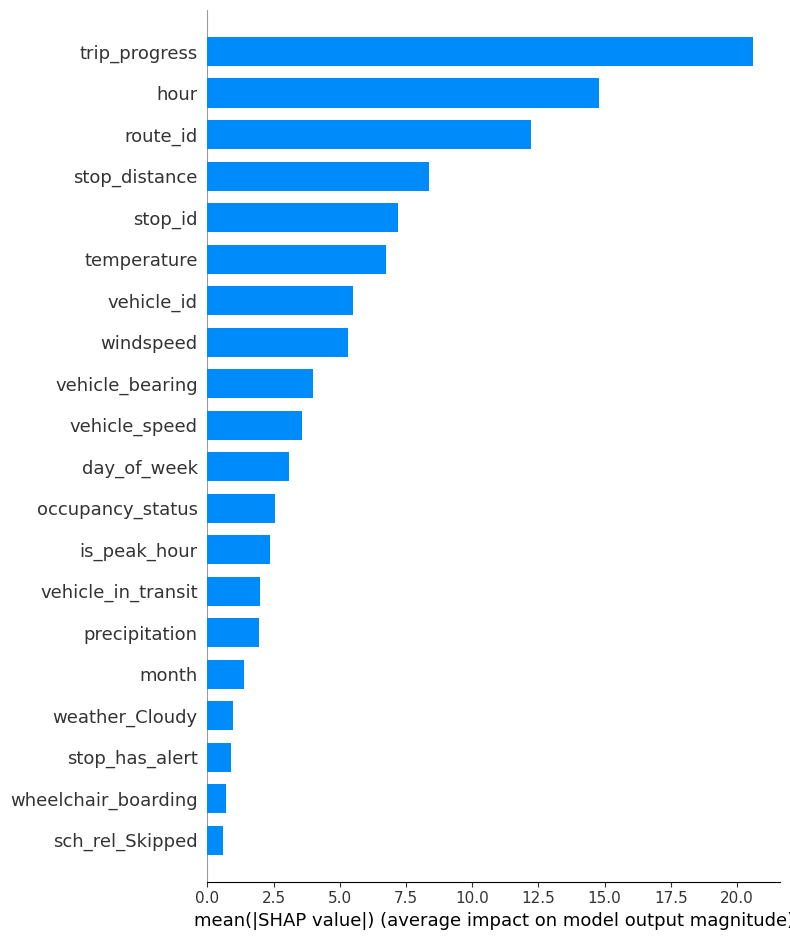

In [14]:
# Summary plot (bar chart)
shap.summary_plot(shap_values, X_val_sample, plot_type='bar')

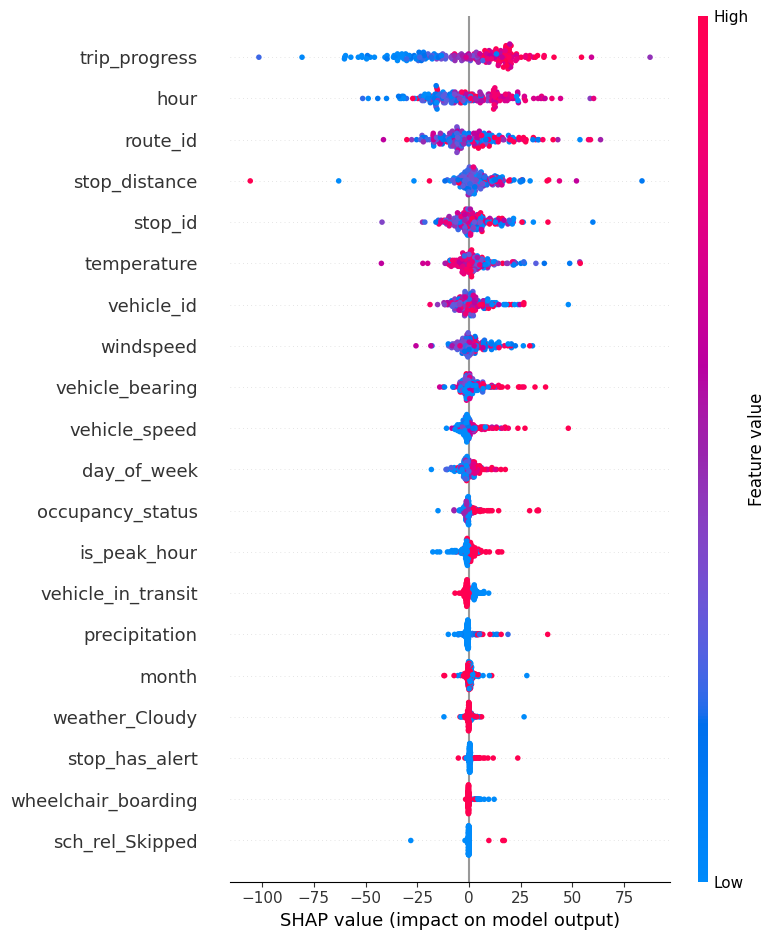

In [15]:
# Summary plot (beeswarm: shows direction and spread)
shap.summary_plot(shap_values, X_val_sample)

In [ ]:
# Force Plot (local explanation for one prediction)
sample_idx = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_val_sample.iloc[sample_idx])

#### Recursive Feature Elimination (RFE)

In [ ]:
rfe_list = []
X_current = X.copy()
X_train_current = X_train.copy()
X_val_current = X_val.copy()
best_rmse = float(metrics_df['RMSE'].min())
best_features = X_train_current.columns.tolist()
patience = 2 # allow 2 RMSE increases before stopping
patience_counter = 0 

keep_going = True

while keep_going and len(X_current.columns) > 5: # keep at least 5 features
	# Fit model
	rf = RandomForestRegressor(
		n_estimators=best_params['n_estimators'],
		min_samples_split=best_params['min_samples_split'],
  		min_samples_leaf=best_params['min_samples_leaf'],
  		max_leaf_nodes=best_params['max_leaf_nodes'],
  		max_depth=best_params['max_depth'],
  		max_features=best_params['max_features'],
		random_state=42,
		n_jobs=-1
	)

	nb_features = len(X_current.columns)
	rf.fit(X_train_current, y_train)

	# Predict and calculate RMSE
	y_pred = rf.predict(X_val_current)
	rmse = root_mean_squared_error(y_val, y_pred)

	rfe = {
		'nb_features': nb_features,
		'rmse': rmse
	}

	# Feature importances
	importances = pd.Series(rf.feature_importances_, index=X_current.columns)
	weakest_feature = importances.idxmin()

	if rmse <= best_rmse:
		best_rmse = rmse
		best_features = X_current.columns.tolist()
		
		# Drop the weakest feature
		print(f'RMSE: {rmse:.4f} | Dropping: {weakest_feature} (importance {importances.min():.6f})')
		X_current = X_current.drop(columns=[weakest_feature], axis=1)
		X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
		X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)

		patience_counter = 0 # reset patience is RMSE improves
		rfe['worsened_point'] = False
		rfe_list.append(rfe)
	else:
		patience_counter += 1
		rfe['worsened_point'] = True
		rfe_list.append(rfe)
		print(f'Patience counter: {patience_counter}/{patience}')

		if patience_counter >= patience:
			print('Performance worsened too much. Stopping feature elimination.')
			keep_going = False
		else:
			# Allow two bad steps: still drop feature and continue
			X_current = X_current.drop(columns=[weakest_feature], axis=1)
			X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
			X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)


rfe_df = pd.DataFrame(rfe_list)

if len(X_current.columns) < len(X.columns):
	print('\nBest set of features found:')
	print('\n'.join(best_features))
	print(f'Final validation RMSE: {best_rmse:.4f}')
else:
	print('The features remain the same.')

In [ ]:
# Plot RSME at each step
plt.figure(figsize=(10,6))
plt.plot(rfe_df['nb_features'], rfe_df['rmse'], marker='o')
plt.gca().invert_xaxis() # Highest number of features on the left
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE')
plt.title('Recursive Feature Elimination Progress')
plt.grid(True)
plt.savefig('../images/rfe_rf_tuned.png', bbox_inches='tight')
plt.show()

In [ ]:
# Keep best features
X_best = X[best_features]
X_train_best = X_train[best_features]
X_val_best = X_val[best_features]

In [ ]:
# Retrain model on reduced features
rf_retrained = RandomForestRegressor(
  	n_estimators=best_params['n_estimators'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_retrained.fit(X_train_best, y_train)

In [ ]:
# Evaluate model
y_pred = rf_retrained.predict(X_val_best)

metrics_df = add_metrics(metrics_df, rf_retrained, y_pred, y_val, 'rf_retrained')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

#### Retune Parameters

In [ ]:
# Random search
start_rmse = float(metrics_df['RMSE'].min())
search = random_search_rf(X_train_best, X_val_best, y_train, y_val, start_rmse, 5)

if not search:
	print('No better parameters were found.')
else:
	best_params = search['best_params']
	print(f'Best parameters found: {best_params} with RMSE: {search['best_rmse']:.4f}')	

#### Revalidate Model

Interpret results

In [ ]:
plot_residuals(y_pred, y_val, 'rf_final')

The plots didn't change much.

Interpret plot

In [ ]:
# Display best model
metrics_df.loc[metrics_df['RMSE'].idxmin(), ['model', 'MAE', 'RMSE', 'R²']]

In [ ]:
# Save best parameters and features
rf_attributes = {
	'best_params': best_params,
  	'best_features': best_features,
}

with open('../models/rf_attributes.pkl', 'wb') as handle:
	pickle.dump(rf_attributes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
rf_final = rf_retrained

In [ ]:
# Save model
joblib.dump(rf_final, '../models/rf_model.pkl')

### XGBoost Regressor

#### Fit Base Model

In [ ]:
# Initialize the XGBoost model with default parameters
xg_base = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [ ]:
# Train a model
xg_base.fit(X_train, y_train)

#### Evaluate model

In [ ]:
y_pred = xg_base.predict(X_val)

metrics_df = add_metrics(metrics_df, xg_base, y_pred, y_val, 'xg_base')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

**MAE:**

This is a significant improvement over the previous models. The model is now, on average, 65.8 seconds off in its predictions, which is a reduction from the previous 69.6 seconds with the Random Forest and Gradient Boosting models.

**RMSE:**

The RMSE has also decreased compared to the previous ensemble model (117.83), indicating that the XGBoost model is performing better and has reduced the impact of large errors.

**R²:**

This is a substantial improvement from 0.247 (with the ensemble model). With an R-squared of 0,318%, the XGBoost model explains more variance in the data, which shows that it's capturing more of the underlying patterns than the previous models.

**Interpretation**

XGBoost is performing better than the previous models (Random Forest and Gradient Boosting ensemble), particularly in terms of MAE and RMSE. The higher R-squared value also suggests that the model is now explaining more of the variance in the target variable.

#### Hyperparameter tuning

In [ ]:
# Create a GridSearchCV object
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
				estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
				param_grid=param_grid,
				cv=3,
				verbose=1,
				n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

In [ ]:
# Best parameters found
print(f'Best parameters: {grid_search.best_params_}')

In [ ]:
# Use the best model
xg_tuned = grid_search.best_estimator_

In [ ]:
# Evaluate the best model
y_pred = xg_tuned.predict(X_val)

metrics_df = add_metrics(metrics_df, xg_tuned, y_pred, y_val, 'xg_tuned')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

**MAE:**

This is a small improvement over the previous MAE of 65.77 seconds. The model is now, on average, 64.2 seconds off in its predictions, which is a good step forward.

**RMSE:**

The RMSE has decreased again, from 112.11 to 110.89 seconds, indicating that the model has become slightly more accurate, especially in handling larger errors.

**R²:**

The R-squared value has increased marginally from 0.318 to 0.322, suggesting that the model is now explaining a bit more of the variance in the data, which is an improvement.

## Classification Model

## Final Model

### Evaluation

### Make Prediction

## End